## Introduction

This is the third in a series of lessons related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first lesson we wrote an ADQL query to collect data from the Gaia database for stars in a region where GD-1 is known to be visible.

In the second lesson, we selected stars whose proper motion is consistent with being in GD-1, in two ways: first, using a Pandas DataFrame and a Boolean Series; then, using ADQL to do the selection on the Gaia server.

The next step in the analysis is to select candidate stars based on photometry.  The following figure from the paper is a color-magnitude diagram for stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The shaded area shows stars with the characteristics we expect for a star in GD-1, which are "older and more metal poor" than stars in the background.

In [247]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia
    !mkdir data

In [248]:
import os

filename = 'gd1_results5.hdf5'

if not os.path.exists(filename):
    !wget https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_results5.hdf5

--2020-08-24 15:35:51--  https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_results5.hdf5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/datacarpentry/astronomy-python/gh-pages/data/gd1_results5.hdf5 [following]
--2020-08-24 15:35:52--  https://raw.githubusercontent.com/datacarpentry/astronomy-python/gh-pages/data/gd1_results5.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.116.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.116.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1462792 (1.4M) [application/octet-stream]
Saving to: ‘gd1_results5.hdf5’

gd1_results5.hdf5   100%[===================>]   1.39M  2.67MB/s    in 0.5s    

2020-08-24 15:35:53 (2.67 MB/s) - ‘gd1_results5.hdf5’ saved [1462792/1462792]



## Reloading the data

Picking up where we left off, let's reload the data from the previous query.

In [250]:
import pandas as pd

filename = 'gd1_results5.hdf5'
dataset_name = 'df5'

df5 = pd.read_hdf(filename, dataset_name)

## Selecting on proper motion again

Maybe cut this section?

In [251]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [252]:
def between(x, low, high):
    """Make a Boolean Series.
    
    x: Pandas Series
    low: lower bound
    high: upper bound
    
    returns: Boolean Series
    """
    return (x > low) & (x < high)

In [253]:
pm_mask = (between(df5['pm_phi1'], pm1_min, pm1_max) & 
            between(df5['pm_phi2'], pm2_min, pm2_max))

pm_mask.sum()

3979

In [254]:
candidates = df5[pm_mask]

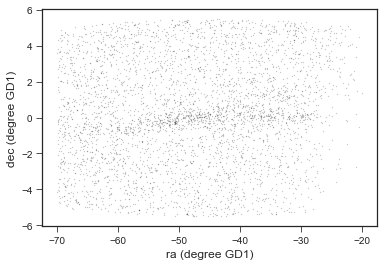

In [255]:
x = candidates['phi1']
y = candidates['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

## Getting photometry data

The Gaia dataset contains some photometry data, including the variable `bp_rp`, which we used in the original query to select stars with BP - RP color between -0.75 and 2.

TODO: Can we say more about what that's meant to do, and where those values come from?

But to select stars with the age and metal richness we expect in GD-1, we will use `g − i` color and apparent `g`-band magnitude, which are available from the Pan-STARRS survey.

Conveniently, the Gaia server provides data from Pan-STARRS as a table in the same database we have been using, so we can access it by making ADQL queries.

In general, looking up a star from the Gaia catalog and finding the corresponding star in the Pan-STARRS catalog is not easy.  This kind of cross matching is not always possible, because a star might appear in one catalog and not the other.  And even when both stars are present, there might not be a clear one-to-one relationship between stars in the two catalogs.

Fortunately, smart people have worked on this problem, and the Gaia database includes cross-matching tables that suggest a best neighbor in the Pan-STARRS catalog for many stars in the Gaia catalog.

[This document describes the cross matching process](https://gea.esac.esa.int/archive/documentation/GDR2/Catalogue_consolidation/chap_cu9val_cu9val/ssec_cu9xma/sssec_cu9xma_extcat.html).

So the hard part of cross-matching has been done for us.  However, using the results is a little tricky.

But, it is also an opportunity to learn about one of the most important tools for working with databases: "joining" tables.

In general, a "join" is an operation where you match up records from one table with records from another table using some kind of identifier as a "key".

In this example:

* Stars in the Gaia dataset are identified by `source_id`.

* Stars in the Pan-STARRS dataset are identified by `obj_id`.

For each candidate star we have selected so far, we have the `source_id`; the goal is to find the `obj_id` for the same star (we hope) in the Pan-STARRS catalog.

To do that we will:

1. Make a table that contains the `source_id` for each candidate star and upload the table to the Gaia server;

2. Use the `JOIN` operator to look up each `source_id` in the `gaiadr2.panstarrs1_best_neighbour` table, which contains the `obj_id` of the best match for each star in the Gaia catalog; then

3. Use the `JOIN` operator again to look up each `obj_id` in the `panstarrs1_original_valid` table, which contains the Pan-STARRS photometry data we want.

Let's start with the first step, uploading a table.

## Preparing a table for uploading

For each candidate star, we want to find the corresponding row in the `gaiadr2.panstarrs1_best_neighbour` table.

In order to do that, we have to:

1. Write the table in a local file as an XML VOTable, which is a format suitable for transmitting a table over a network.

2. Write an ADQL query that refers to the uploaded table.

3. Change the way we submit the job so it uploads the table before running the query.

The first step is not too difficult because Astropy provides a function called `writeto` that can write a `Table` in `XML`.

[The documentation of this process is here](https://docs.astropy.org/en/stable/io/votable/).

First we have to convert our Pandas `DataFrame` to an Astropy `Table`.

In [256]:
candidate_table = Table.from_pandas(candidates)
type(candidate_table)

astropy.table.table.Table

Now we can use `writeto` to write the file.

In [257]:
from astropy.io.votable import from_table, writeto

votable = from_table(candidate_table[['source_id']])
writeto(votable, 'candidates.xml')

Notice that we select a single column from the table, `source_id`.
We could write the entire table to a file, but that would take longer to transmit over the network, and we really only need one column.

This process, taking a structure like a `Table` and translating it into a form that can be transmitted over a network, is called [serialization](https://en.wikipedia.org/wiki/Serialization).

XML is one of the most common serialization formats.  One nice feature is that XML data is plain text, as opposed to binary digits, so you can read the file we just wrote:

In [258]:
!head candidates.xml

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 4.0.1.post1
     http://www.astropy.org/ -->
<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="source_id" datatype="long" name="source_id"/>
   <DATA>
    <TABLEDATA>
     <TR>


XML is a general format, so different XML files contain different kinds of data.  In order to read an XML file, it's not enough to know that it's XML; you also have to know the data format, which is called a [schema](https://en.wikipedia.org/wiki/XML_schema).

In this example, the schema is VOTable; notice that one of the first tags in the file specifies the schema, and even includes the URL where you can get its definition.

So this is an example of a self-documenting format.

A drawback of XML is that it tends to be big.  In this example, the table has about 4000 element.

In [259]:
len(candidates)

3979

The elements are 64-bit integers, which is 8 bytes, but the total size of the file is about 55 bytes for each element.

In [260]:
import os

size = os.path.getsize('candidates.xml')
size, size/len(candidates)

(219353, 55.127670268911785)

So XML is not the most space efficient, but the size of this file is about 200 KB, so that's not too bad.

In [261]:
print(size / 1024, 'KiB')

214.2119140625 KiB


**Exercise:** There's a gotcha here we want to warn you about.  Why do you think we used double brackets to specify the column we wanted?  What happens if you use single brackets?

Run these cells to find out.

In [262]:
table = candidate_table[['source_id']]
type(table)

astropy.table.table.Table

In [263]:
column = candidate_table['source_id']
type(column)

astropy.table.column.Column

In [264]:
# writeto(column, 'candidates.xml')

## Uploading a table

The next step is to upload this table to the Gaia server and use it as part of a query.

[Here's the documentation that explains how to run a query with an uploaded table](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#synchronous-query-on-an-on-the-fly-uploaded-table).

In the spirit of incremental development and testing, let's start with the simplest possible query.

In [265]:
query = """SELECT *
FROM tap_upload.candidates
"""

This query downloads all rows and all columns from the uploaded table.  The name of the table has two parts: `tap_upload` specifies a table that was uploaded using TAP+ (remember that's the name of the protocol we're using to talk to the Gaia server).

And `candidates` is the name of the table, which we get to choose (unlike `tap_upload`, which we didn't get to choose).

Here's how we run the query:

In [266]:
from astroquery.gaia import Gaia

In [267]:
job = Gaia.launch_job_async(query=query, 
                            upload_resource='candidates.xml', 
                            upload_table_name='candidates')

INFO: Query finished. [astroquery.utils.tap.core]


`upload_resource` specifies the name of the file we want to upload, which is the file we just wrote.

`upload_table_name` is the name we assign to this table, which is the name we used in the query.

And here are the results:

In [268]:
results = job.get_results()
results

source_id
int64
635559124339440000
635674126383965568
635614168640132864
635821980633338624
635518889086133376
635580294233854464
635616539462230400
635877570395672448
635500953302563712


If things go according to plan, the result should contain the same rows and columns as the uploaded table.

In [269]:
len(candidate_table), len(results)

(3979, 3979)

In [270]:
set(candidate_table['source_id']) == set(results['source_id'])

True

In this example, we uploaded a table and then downloaded it again, so that's not too useful.

But now that we can upload a table, we can join it with other tables on the Gaia server.

## Joining with an uploaded table

Here's the first example of a query that contains a `JOIN` clause.

In [271]:
query6 = """SELECT *
FROM gaiadr2.panstarrs1_best_neighbour as best
JOIN tap_upload.candidates as candidates
ON best.source_id = candidates.source_id
"""

Let's break that down one clause at a time:

* `SELECT *` means we will download the entire result of the join operation.

* `FROM gaiadr2.panstarrs1_best_neighbour as best` means that we'll get the columns from the Pan-STARRS best neighbor table, which we'll refer to using the short name `best`.

* `JOIN tap_upload.candidates as candidates` means that we'll also get columns from the uploaded table, which we'll refer to using the short name `candidates`.

* `ON best.source_id = candidates.source_id` specifies that we will use `source_id ` to match up the rows from the two tables.

Here's the [documentation of the best neighbor table](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_crossmatches/ssec_dm_panstarrs1_best_neighbour.html).

Let's run the query:

In [272]:
job6 = Gaia.launch_job_async(query=query6, 
                       upload_resource='candidates.xml', 
                       upload_table_name='candidates')

INFO: Query finished. [astroquery.utils.tap.core]


And get the results.

In [273]:
results6 = job6.get_results()
results6

source_id,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,gaia_astrometric_params,source_id_2
,,arcsec,,,,,
int64,int64,float64,int32,int16,int16,int16,int64
635674126383965568,130831388428488720,0.038810268141577516,1,0,1,5,635674126383965568
635614168640132864,130571395922140135,0.020304189709964143,1,0,1,5,635614168640132864
635877570395672448,131071382899919816,0.02836059164198281,1,0,1,5,635877570395672448
635850945892748672,132011398654934147,0.021178742393378396,1,0,1,5,635850945892748672
635600532119713664,130421392285893623,0.04518820915043015,1,0,1,5,635600532119713664
635620701286087424,130651396862917914,0.041749828900538036,1,0,1,5,635620701286087424
635832357274302208,131781401302206851,0.03681655435731799,1,0,1,5,635832357274302208
635593552797727488,130261390007297700,0.04358842687796336,1,0,1,5,635593552797727488


This table contains all of the columns from the best neighbor table, plus the single column from the uploaded table.

In [274]:
results6.colnames

['source_id',
 'original_ext_source_id',
 'angular_distance',
 'number_of_neighbours',
 'number_of_mates',
 'best_neighbour_multiplicity',
 'gaia_astrometric_params',
 'source_id_2']

Because one of the column names appears in both tables, the second instance of `source_id` has been appended with the suffix `_2`.

The length of the results table is about 2000, which means we were not able to find matches for all stars in the list of candidates.

In [275]:
len(results6)

1990

To get more information about the matching process, we can inspect `best_neighbour_multiplicity`, which indicates for each star in Gaia how many stars in Pan-STARRS are equally likely matches.

For this kind of data exploration, we'll convert a column from the table to a Pandas `Series`, which provides `value_counts`.

In [276]:
import pandas as pd

nn = pd.Series(results6['best_neighbour_multiplicity'])
nn.value_counts()

1    1990
dtype: int64

The result shows that `1` is the only value in the `Series`, appearing 1990 times.

That means that in every case where a match was found, the matching algorithm identified a single neighbor as the most likely match.

Similarly, `number_of_mates` indicates the number of other stars in Gaia that match with the same star in Pan-STARRS.

In [277]:
nm = pd.Series(results6['number_of_mates'])
nm.value_counts()

0    1990
dtype: int64

For this set of candidates, there are no mates; that is, each of the stars we've selected from Pan-STARRS is only matched with a single star in the Gaia catalog.

**Detail in case someone asks** The table also contains `number_of_neighbors` which is the number of stars in Pan-STARRS that match in terms of position, before using other critieria to choose the most likely match.

## Getting the photometry data

The most important column in `results6` is `original_ext_source_id` which is the ID we will use to look up the likely matches in Pan-STARRS to get photometry data.

The process is similar to what we just did to look up the matches.  We will:

1. Make a table that contains `source_id` and `original_ext_source_id`.

2. Write the table to an XML VOTable file.

3. Write a query that joins the uploaded table with `gaiadr2.panstarrs1_original_valid` and selects the photometry data we want.

4. Run the query using the uploaded table.

Since we've done everything here before, we'll do these steps as an exercise.

**Exercise:** Select `source_id` and `original_ext_source_id` from `results6` and write the resulting table as a file named `external.xml`.

In [278]:
# Solution

from astropy.io.votable import from_table, writeto

votable = from_table(results6[['source_id',
                               'original_ext_source_id']])
writeto(votable, 'external.xml')

Use `!head` to confirm that the file exists and contains an XML VOTable.

In [279]:
!head external.xml

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 4.0.1.post1
     http://www.astropy.org/ -->
<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="source_id" datatype="long" name="source_id" ucd="meta.id;meta.main">
    <DESCRIPTION>
     Unique Gaia source identifier
    </DESCRIPTION>


**Exercise:** Read [the documentation of the Pan-STARRS table](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_external_catalogues/ssec_dm_panstarrs1_original_valid.html) and make note of `obj_id`, which contains the object IDs we'll use to find the rows we want.

Write a query that uses each value of `original_ext_source_id` from the uploaded table to find a row in `gaiadr2.panstarrs1_original_valid` with the same value in `obj_id`, and select all columns from both tables.

Suggestion: Develop and test your query incrementally.  For example:

1. Write a query that downloads all columns from the uploaded table.  Test to make sure we can read the uploaded table.

2. Write a query that downloads the first 10 rows from `gaiadr2.panstarrs1_original_valid`.  Test to make sure we can access Pan-STARRS data.

3. Write a query that joins the two tables and selects all columns.  Test that the join works as expected.


As a bonus exercise, write a query that joins the two tables and selects just the columns we need:

* `source_id` from the uploaded table

* `g_mean_psf_mag` from `gaiadr2.panstarrs1_original_valid`

* `i_mean_psf_mag` from `gaiadr2.panstarrs1_original_valid`

Hint: When you select a column from a join, you have to specify which table the column is in.

In [280]:
# Solution

query7 = """SELECT *
FROM tap_upload.external as external
"""

In [281]:
# Solution

query7 = """SELECT TOP 10 *
FROM gaiadr2.panstarrs1_original_valid
"""

In [282]:
# Solution

query7 = """SELECT *
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id
"""

In [283]:
# Solution

query7 = """SELECT
external.source_id, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id
"""

In [284]:
print(query7)

SELECT
external.source_id, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id



In [285]:
job7 = Gaia.launch_job_async(query=query7, 
                       upload_resource='external.xml', 
                       upload_table_name='external')

INFO: Query finished. [astroquery.utils.tap.core]


In [286]:
results7 = job7.get_results()
results7

source_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
635674126383965568,19.2873001098633,17.6781005859375
635614168640132864,16.1515998840332,14.6662998199463
635877570395672448,21.839599609375,19.7248001098633
635850945892748672,16.5174999237061,16.0450000762939
635600532119713664,20.4505996704102,19.5177001953125
635620701286087424,20.4113006591797,19.5032997131348
635832357274302208,20.4759006500244,18.8048000335693
635593552797727488,20.6061992645264,18.8955001831055


**Challenge exercise**

Do both joins in one query.

There's an [example here](https://github.com/smoh/Getting-started-with-Gaia/blob/master/gaia-adql-snippets.md) you could start with.

## Plotting photometry data

Now that we have photometry data from Pan-STARRS, we can replicate the [color-magnitude diagram](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram) from the original paper:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The y-axis shows the magnitude of each source with the [g filter](https://en.wikipedia.org/wiki/Photometric_system).

The x-axis shows the difference in magnitude between the g and i filters, which indicate... (TODO: what does this indicate)



In [287]:
def plot_cmd(table):
    """Plot a color magnitude diagram.
    
    table: Table or DataFrame with photometry data
    """
    y = table['g_mean_psf_mag']
    x = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.6, alpha=0.6)

    plt.xlim([0, 1.5])
    plt.ylim([14, 22])
    plt.gca().invert_yaxis()

    plt.ylabel('$g_0$')
    plt.xlabel('$(g-i)_0$');

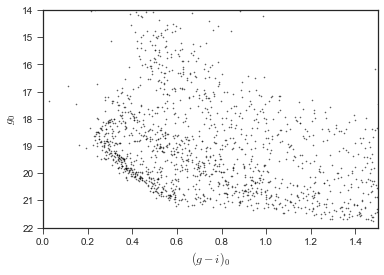

In [288]:
plot_cmd(results7)

Our figure does not look exactly like theirs because we are working with a smaller region of the sky, so we don't have as many stars.  But we can see an overdense region in the lower left that contains stars with the photometry we expect for GD-1.

The authors of the original paper derive a detailed polygon that defines a boundary between stars that are likely to be in GD-1 or not.

As a simplification, we'll choose a boundary by eye that seems to contain the overdense region.

## Drawing a polygon

Matplotlib provides a function called `ginput` that lets us click on the figure and make a list of coordinates.

It's a little tricky to use `ginput` in a Jupyter notebook.  
Before calling `plt.ginput` we have to tell Matplotlib to use `TkAgg` to draw the figure in a new window.

When you run the following cell, a figure should appear in a new window.  Click on it 16 times to draw a polygon around the overdense area.  A red cross should appear where you click.

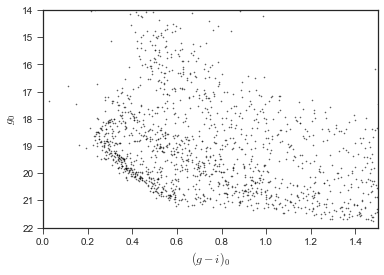

In [289]:
import matplotlib
matplotlib.use('TkAgg')

plot_cmd(results7)

coords = plt.ginput(16)

The argument to `ginput` is the number of times the user has to click on the figure.

The result from `ginput` is a list of coordinate pairs.

In [290]:
coords

[(0.3629032258064516, 17.84253127299485),
 (0.3629032258064516, 18.431199411331864),
 (0.4032258064516129, 19.093451066961002),
 (0.546594982078853, 19.866077998528333),
 (0.6630824372759856, 20.454746136865342),
 (0.7795698924731183, 21.00662251655629),
 (0.7347670250896057, 21.41133186166299),
 (0.5913978494623655, 21.44812362030905),
 (0.44802867383512546, 20.933038999264166),
 (0.3091397849462365, 20.123620309050775),
 (0.2329749103942652, 19.498160412067698),
 (0.17025089605734767, 18.94628403237675),
 (0.17025089605734767, 18.3944076526858),
 (0.21057347670250892, 18.063281824871233),
 (0.2643369175627239, 17.805739514348787),
 (0.31810035842293904, 17.695364238410598)]

If `ginput` doesn't work for you, you could use the following coordinates.

```
coords = [(0.2, 17.5), 
          (0.2, 19.5), 
          (0.65, 22),
          (0.75, 21),
          (0.4, 19),
          (0.4, 17.5)]
```

The next step is to convert the coordinates to a format we can use to plot them, which is a sequence of `x` coordinates and a sequence of `y` coordinates.  The NumPy function `transpose` does what we want. 

In [291]:
import numpy as np

xs, ys = np.transpose(coords)
xs, ys

(array([0.36290323, 0.36290323, 0.40322581, 0.54659498, 0.66308244,
        0.77956989, 0.73476703, 0.59139785, 0.44802867, 0.30913978,
        0.23297491, 0.1702509 , 0.1702509 , 0.21057348, 0.26433692,
        0.31810036]),
 array([17.84253127, 18.43119941, 19.09345107, 19.866078  , 20.45474614,
        21.00662252, 21.41133186, 21.44812362, 20.933039  , 20.12362031,
        19.49816041, 18.94628403, 18.39440765, 18.06328182, 17.80573951,
        17.69536424]))

To display the polygon, we'll 

1. Tell Matlab to switch back to `agg`, which displays figures in the notebook, 

2. Draw the figure again, and

3. Use `plt.plot` to draw the polygon.

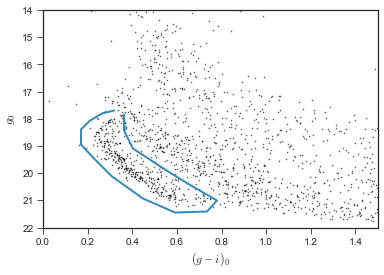

In [292]:
matplotlib.use('agg')

plot_cmd(results7)
plt.plot(xs, ys);

If it looks like your polygon does a good job surrounding the overdense area, go on to the next section.  Otherwise you can try again.

The polygon does not have to be "closed"; when we use this polygon in the next section, the last and first points will be connected by a straight line.


## Which points are in the polygon?

Matplotlib provides a `Path` object that we can use to check which points fall in the polygon we selected.

Here's how we make a `Path` using a list of coordinates.

In [293]:
from matplotlib.path import Path

path = Path(coords)
path

Path(array([[ 0.36290323, 17.84253127],
       [ 0.36290323, 18.43119941],
       [ 0.40322581, 19.09345107],
       [ 0.54659498, 19.866078  ],
       [ 0.66308244, 20.45474614],
       [ 0.77956989, 21.00662252],
       [ 0.73476703, 21.41133186],
       [ 0.59139785, 21.44812362],
       [ 0.44802867, 20.933039  ],
       [ 0.30913978, 20.12362031],
       [ 0.23297491, 19.49816041],
       [ 0.1702509 , 18.94628403],
       [ 0.1702509 , 18.39440765],
       [ 0.21057348, 18.06328182],
       [ 0.26433692, 17.80573951],
       [ 0.31810036, 17.69536424]]), None)

`Path` provides `contains_points`, which figures points are inside the polygon.

To test it, we'll create a list with two points, one inside the polygon and one outside.

In [294]:
points = [(0.4, 20), 
          (0.4, 30)]

Now we can make sure `contains_points` does what we expect.

In [295]:
inside = path.contains_points(points)
inside

array([ True, False])

The result is an array of Boolean values.

We are almost ready to select stars whose photometry data falls in this polygon.  But first we need to do some data cleaning.

## Back to Pandas

Before we select stars based on photometry data, we have to solve two problems:

1. We only have Pan-STARRS data for some stars in `candidates`.

2. Even for the stars where we have Pan-STARRS data in `results7`, some photometry data is missing.

We will solve these problems in two step:

1. We'll merge the data from `candidates` and `results7` into a single Pandas `DataFrame`.

2. We'll use Pandas functions to deal with missing data.

`candidates` is already a `DataFrame`, but `results` is an Astropy `Table`.  Let's convert it to Pandas:

In [296]:
df7 = results7.to_pandas()
df7.columns

Index(['source_id', 'g_mean_psf_mag', 'i_mean_psf_mag'], dtype='object')

Now we want to combine `candidates` and `df7` into a single table, using `source_id` to match up the rows.

You might recognize this task; it's the same as the JOIN operation in ADQL/SQL.

Pandas provides a function called `merge` that does what we want.  Here's how we use it.

In [297]:
merged = pd.merge(candidates, 
                  df7, 
                  on='source_id', 
                  how='left')
merged.head()

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2,g_mean_psf_mag,i_mean_psf_mag
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633,NaN,NaN
1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800,19.2873,17.678101
2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,0.583382,0.574618,NaN,-58.938113,-3.024192,-8.062762,-1.869082,16.1516,14.666300
3,635821980633338624,139.908031,19.638380,-4.045392,-11.966805,0.217321,0.425852,NaN,-58.077902,-2.822939,-6.954525,-0.324265,NaN,NaN
4,635518889086133376,137.237423,18.742863,-3.318680,-12.710315,0.179325,0.750338,NaN,-60.190484,-1.177975,-7.340183,-1.064063,NaN,NaN


The first argument is the "left" table, the second argument is the "right" table, and the keyword argument `on='source_id'` specifies a column to use to match up the rows.

The argument `how='left'` means that the result should have all rows from the left table, even if some of them don't match up with a row in the right table.

If you are interested in the other options for `how`, you can [read the documentation of `merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html).

The result is a `DataFrame` that contains the same number of rows as `candidates`. 

In [298]:
len(candidates), len(df7), len(merged)

(3979, 1990, 3979)

And all columns from both tables.

In [299]:
merged.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error',
       'radial_velocity', 'phi1', 'phi2', 'pm_phi1', 'pm_phi2',
       'g_mean_psf_mag', 'i_mean_psf_mag'],
      dtype='object')

**Detail in case anyone asks** You might notice that Pandas also provides a function called `join`; it does almost the same thing, but the interface is slightly different.  We think `merge` is a little easier to use, so that's what we chose.

## Missing data

Let's add columns to the merged table for magnitude and color.

In [300]:
merged['y'] = merged['g_mean_psf_mag']
merged['x'] = merged['g_mean_psf_mag'] - merged['i_mean_psf_mag']

These columns contain the special value `NaN` where we are missing data.

We can use `notnull` to see which rows contain value data, that is, not null values.

In [301]:
merged['x'].notnull()

0       False
1        True
2        True
3       False
4       False
        ...  
3974     True
3975     True
3976     True
3977     True
3978     True
Name: x, Length: 3979, dtype: bool

And `sum` to count the number of valid values.

In [302]:
merged['x'].notnull().sum()

1952

It's not obvious what we should do with candidate stars if we don't have photometry data.  Should we give them the benefit of the doubt or leave them out.

In the next section, we'll leave them out, but you can experiment with the alternative.

## Selecting based on photometry

Now let's see how many of these points are inside the polygon we chose.

We can use a list of column names to select `x` and `y`.

In [303]:
points = merged[['x', 'y']]
points.head()

,x,y
0,NaN,NaN
1,1.6092,19.2873
2,1.4853,16.1516
3,NaN,NaN
4,NaN,NaN


The result is a `DataFrame` that can be treated as a sequence of coordinates, so we can pass it to `contains_points`:

In [304]:
inside = path.contains_points(points)
inside

array([False, False, False, ..., False, False, False])

The result is a Boolean array.  We can use `sum` to see how many stars fall in the polygon.

In [305]:
inside.sum()

376

Now we can use `inside` as a mask to select stars that fall inside the polygon.

In [306]:
selected = merged[inside]

Let's make a color-magnitude plot one more time, highlighting the selected stars with green `x` marks.

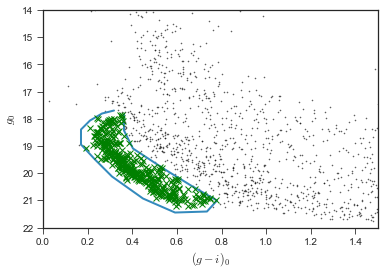

In [307]:
plot_cmd(results7)
plt.plot(xs, ys)

plt.plot(selected['x'], selected['y'], 'gx');

It looks like the selected stars are, in fact, inside the polygon, which means they have photometry data consistent with GD-1.

Finally, we can plot the coordinates of the selected stars:

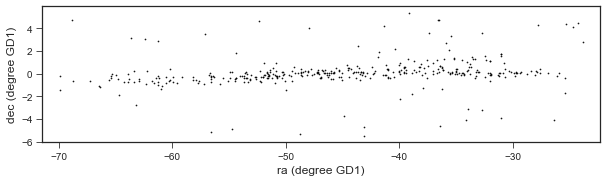

In [308]:
plt.figure(figsize=(10,2.5))

x = selected['phi1']
y = selected['phi2']

plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');

This example includes two new Matplotlib commands:

* `figure` creates the figure.  In previous examples, we didn't have to use this function; the figure was created automatically.  But when we call it explicitly, we can provide arguments like `figsize`, which sets the size of the figure.

* `axis` with the parameter `equal` sets up the axes so a unit is the same size along the `x` and `y` axes.

## Style sheets

This section is still in progress.

The original uses `gd1_paper`, which doesn't seem to be in the repo.

TODO: See if we can get this style sheet, or find out what it is based on.

[Documentation of style sheets is here](https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html)

In [309]:
plt.style.use('seaborn-ticks')


Text(-60, 9.5, 'Previously\nundetected')

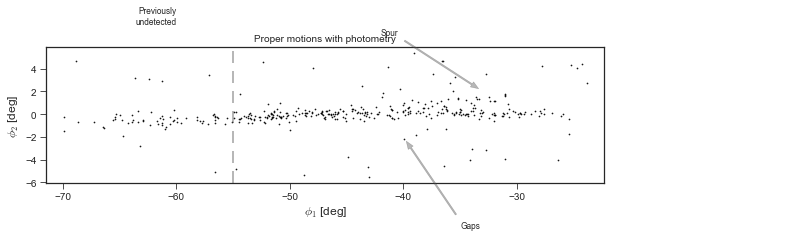

In [310]:
plt.figure(figsize=(10,2.5))

x = selected['phi1']
y = selected['phi2']

plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motions with photometry', fontsize='medium')


plt.axis('equal');

arrowprops=dict(color='0.3', shrink=0.05, width=1.5, 
                headwidth=6, headlength=8, alpha=0.4)

plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
             arrowprops=arrowprops,
             fontsize='small')

plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
             arrowprops=arrowprops,
             fontsize='small')

plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
             arrowprops=arrowprops,
             fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=arrowprops,
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=arrowprops,
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=2)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')